In [1]:
from datetime import datetime
from importlib import reload
from time import time
import netCDF4 as nc
import ascat.read_native.ragged_array_ts as rat
from ascat.read_native.ragged_array_ts import SwathFileCollection
from ascat.read_native import xarray_io
import numpy as np
import xarray as xr
import geopandas as gpd
import osmnx as ox
import os
import folium
import pandas as pd
import matplotlib.pyplot as plt

_____________________________

### Reading and combining ascat cells

In [2]:
# this code filters ascat cells by bounding box and time frame, combines the the cell data and saves it as csv ("area_ascat.csv")

import numpy as np
import pandas as pd
import os

# Paths and setup
cell_source = "/home/jlinke/shares/exchange/students/julian/ASCAT_Mozambique_data_fixed/"
output_dirs = [
    "/home/jlinke/Documents/Geo/drysat/sync/test1",
    "/home/jlinke/Documents/Geo/drysat/sync/test2"
]

collection = rat.CellFileCollection.from_product_id(cell_source, product_id="H121_v1.0")

# Define areas of interest
areas = {
    "Buzi": {
        "lat_min": -20.5695588, "lat_max": -19.582687,
        "lon_min": 33.8931254, "lon_max": 34.8127126
    },
    "Chokwé": {
        "lat_min": -24.8651389, "lat_max": -24.1120627,
        "lon_min": 32.5596257, "lon_max": 33.5225846
    },
    "Mabalane": {
        "lat_min": -24.1967515, "lat_max": -22.9668694,
        "lon_min": 32.2377105, "lon_max": 33.2483723
    },
    "Mabote": {
        "lat_min": -22.9057726, "lat_max": -21.3023939,
        "lon_min": 33.1611587, "lon_max": 34.6342067
    },
    "Muanza": {
        "lat_min": -19.5313462, "lat_max": -18.6416478,
        "lon_min": 34.4736235, "lon_max": 35.6973266
    }
}

# Define time range
start_date = np.datetime64("2024-01-01")
end_date = np.datetime64("2024-12-31")

# Process each area
for area_name, bounds in areas.items():
    time_series_data = []

    for cell_id in [1524, 1525, 1526]:  # Add more IDs as needed
        data = collection.read(cell=cell_id)
        data["location_id"].load()
        data["locationIndex"].load()
        data["location_id"] = data["location_id"][data["locationIndex"]]
        data["lon"] = data["lon"][data["locationIndex"]]
        data["lat"] = data["lat"][data["locationIndex"]]

        if "time" not in data.coords:
            data = data.set_index(time="time")

        data_filt = data["surface_soil_moisture"].where(
            (data["lat"] >= bounds["lat_min"]) & (data["lat"] <= bounds["lat_max"]) &
            (data["lon"] >= bounds["lon_min"]) & (data["lon"] <= bounds["lon_max"]) &
            (data["time"] >= start_date) & (data["time"] <= end_date),
            drop=True
        )

        if data_filt.size > 0:
            df = data_filt.to_dataframe().reset_index()
            df["time"] = pd.to_datetime(df["time"]).dt.floor("h")
            hourly_avg = df.groupby("time")["surface_soil_moisture"].mean().reset_index()
            time_series_data.append(hourly_avg)

    if time_series_data:
        final_df = pd.concat(time_series_data).groupby("time")["surface_soil_moisture"].mean().reset_index()
        final_df.rename(columns={"time": "datetime", "surface_soil_moisture": "avg_soil_moisture"}, inplace=True)

        for output_dir in output_dirs:
            os.makedirs(output_dir, exist_ok=True)

            # Save ASCAT data
            ascat_path = os.path.join(output_dir, f"{area_name}_ascat.csv")
            final_df.to_csv(ascat_path, index=False)
            print(f"Saved ASCAT: {ascat_path}")

           


/home/jlinke/anaconda3/envs/drysat/lib/python3.13/site-packages/ascat/read_native/ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'ASCAT_Mozambique_data_fixed' from directory name. Using min/max datetime from files instead.
  warnings.warn(


Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Buzi_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Buzi_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Chokwé_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Chokwé_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Mabalane_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Mabalane_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Mabote_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Mabote_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Muanza_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Muanza_ascat.csv


### Merging ground and ascat data into a wide table

In [21]:
# after having troubles with inplace = True later on in the plotting code block this code block also needs an update 

import pandas as pd
import numpy as np
import glob
import os

# Define file paths
ground_files = glob.glob("/home/jlinke/Documents/Geo/drysat/sync/test2/*_ground.csv")
ascat_files = glob.glob("/home/jlinke/Documents/Geo/drysat/sync/test2/*_ascat.csv")

# Function to process and merge to wide table
def merge_to_wide(ground_file, ascat_file):
    ground = pd.read_csv(ground_file)
    ascat = pd.read_csv(ascat_file)

    # Drop unused columns if they exist
    cols_to_drop = ["Unnamed: 0", "mrid", "rssi", "port", "error", "units", "description"]
    ground = ground.drop(columns=[col for col in cols_to_drop if col in ground.columns])

    ground["datetime"] = pd.to_datetime(ground["datetime"]).dt.tz_localize(None)
    ascat["datetime"] = pd.to_datetime(ascat["datetime"]).dt.tz_localize(None)


    '''
    # Convert datetime to hourly, remove timezone
    ground["datetime"] = ground["datetime"].dt.floor("h")
    ascat["datetime"] = ascat["datetime"].dt.floor("h")
    # Mean over duplicate timestamps (if any)
    ground_grouped = ground.groupby("datetime", as_index=False)["in-situ m³/m³"].mean()

    '''



    # Filter ground data to desired time range
    #ground = ground[(ground["datetime"] >= "2020-01-01") & (ground["datetime"] <= "2024-12-31")] #limit already set in drysat_ground.ipynb
    ground.rename(columns={"value": "in-situ m³/m³"}, inplace=True)
    ascat.rename(columns={"avg_soil_moisture": "ascat %"}, inplace=True)



    # Merge on datetime (left join to keep all in-situ data)
    merged = ground.merge(ascat[["datetime", "ascat %"]], how="left", on="datetime")

    
    '''
    # So this part should be done by the students later on!

    # Min-Max normalizing
    # We use the vectorization of pandas to make it fast
    def normal(array):
        return((array-array.min())/(array.max()- array.min()))
    

    # In-situ data normalize and scaled to 0-100 like the ascat data
    merged["in-situ m³/m³"]=normal(merged["in-situ m³/m³"])*100
    merged.rename(columns={"in-situ m³/m³": "in-situ %"})

    '''


    # Add location column from filename
    location_name = os.path.splitext(os.path.basename(ground_file))[0].replace("_ground", "")
    merged["location"] = location_name

    return merged

# List to collect all location data
all_data = []

# Process and collect
for ground_file, ascat_file in zip(ground_files, ascat_files):
    print(f"Processing (wide): {ground_file} and {ascat_file}")
    merge_wide = merge_to_wide(ground_file, ascat_file)
    all_data.append(merge_wide)

# Combine all into one wide-format DataFrame
combined_df = pd.concat(all_data, ignore_index=True)

# Optional: set datetime as index
#combined_df.set_index("datetime", inplace=True)

# Save to CSV
output_path = "/home/jlinke/Documents/Geo/drysat/sync/test2/merge_wide/ALL_areas_merge_wide.csv"
combined_df.to_csv(output_path)

print(f"Saved combined wide merge to: {output_path}")


Processing (wide): /home/jlinke/Documents/Geo/drysat/sync/test2/Mabalane_ground.csv and /home/jlinke/Documents/Geo/drysat/sync/test2/Mabalane_ascat.csv
Processing (wide): /home/jlinke/Documents/Geo/drysat/sync/test2/Chokwé_ground.csv and /home/jlinke/Documents/Geo/drysat/sync/test2/Muanza_ascat.csv
Processing (wide): /home/jlinke/Documents/Geo/drysat/sync/test2/Buzi_ground.csv and /home/jlinke/Documents/Geo/drysat/sync/test2/Chokwé_ascat.csv
Processing (wide): /home/jlinke/Documents/Geo/drysat/sync/test2/Muanza_ground.csv and /home/jlinke/Documents/Geo/drysat/sync/test2/Buzi_ascat.csv
Processing (wide): /home/jlinke/Documents/Geo/drysat/sync/test2/Mabote_ground.csv and /home/jlinke/Documents/Geo/drysat/sync/test2/Mabote_ascat.csv
Saved combined wide merge to: /home/jlinke/Documents/Geo/drysat/sync/test2/merge_wide/ALL_areas_merge_wide.csv


In [22]:
# just some testing

data = pd.read_csv('/home/jlinke/Documents/Geo/drysat/sync/test2/merge_wide/ALL_areas_merge_wide.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

start_date = '2024-01-01 00:00:00'  
end_date = '2024-01-07 00:00:00'  

print(data.dtypes)

location_data = data[data['location'] == "Buzi"].copy()

location_data['datetime'] = pd.to_datetime(location_data['datetime'])

#location_data = location_data[(location_data['datetime'] >= pd.to_datetime(start_date)) & (location_data['datetime'] <= pd.to_datetime(end_date))]
location_data = location_data[(location_data['datetime'] >= start_date) & (location_data['datetime'] <= end_date)]



print(location_data.dtypes)


Unnamed: 0                int64
datetime         datetime64[ns]
in-situ m³/m³           float64
ascat %                 float64
location                 object
dtype: object
Unnamed: 0                int64
datetime         datetime64[ns]
in-situ m³/m³           float64
ascat %                 float64
location                 object
dtype: object


### Plotting the ground and ascat data with wide table

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

#pd.options.mode.copy_on_write = False





# Function to plot the line graph for a chosen location and time frame
def plot_location_data(data ,location_name, start_date, end_date):


    # Convert 'datetime' column to datetime type
    data['datetime'] = pd.to_datetime(data['datetime'], errors="coerce")

    # Filter data for the chosen location
    location_data = data[data['location'] == location_name].copy()
 

    # Filter data for the chosen time frame
    
    location_data = location_data[(location_data['datetime'] >= pd.to_datetime(start_date)) & (location_data['datetime'] <= pd.to_datetime(end_date))]

    
    # Interpolating the missing ascat values before plotting
    location_data['ascat %'] = location_data['ascat %'].bfill(axis=0, limit=1)

    location_data = location_data.set_index("datetime")
  
    location_data['ascat interpolated'] = location_data['ascat %'].interpolate(method='time')
    
    # Plotting the graphs in the same row
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # First plot: Regular ground and ascat data
    axes[0].plot(location_data.index, location_data['in-situ m³/m³'], label='Ground Data (in-situ)', color='tab:blue')
    axes[0].plot(location_data.index, location_data['ascat interpolated'], label='ASCAT Data', color='tab:orange')
    axes[0].set_title(f'Soil Moisture Data for {location_name} (Regular)')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Soil Moisture (%)') 
    axes[0].legend()
    axes[0].tick_params(axis='x', rotation=45)

    # Second plot: Ground data and rolling mean of ascat data


    location_data['ascat_rolling'] = location_data['ascat interpolated'].rolling(window=10, min_periods=1).mean()
    axes[1].plot(location_data.index, location_data['in-situ m³/m³'], label='Ground Data (in-situ)', color='tab:blue')
    axes[1].plot(location_data.index, location_data['ascat_rolling'], label='ASCAT Data (Rolling Mean)', color='tab:red')
    axes[1].set_title(f'Soil Moisture Data for {location_name} (Rolling Mean)')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Soil Moisture (%)')
    axes[1].legend()
    axes[1].tick_params(axis='x', rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()




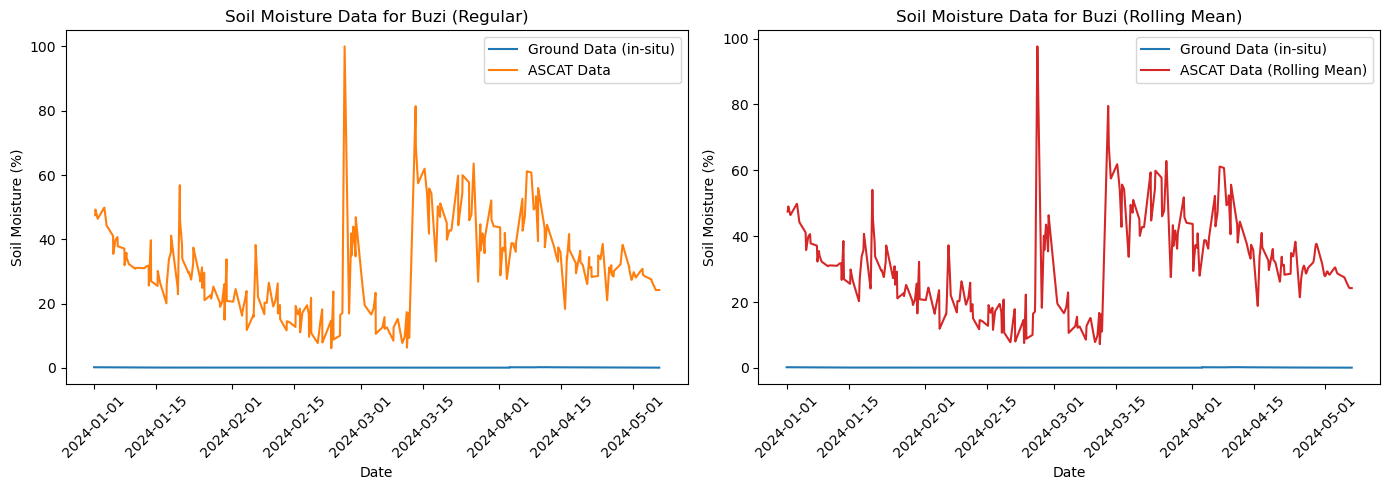

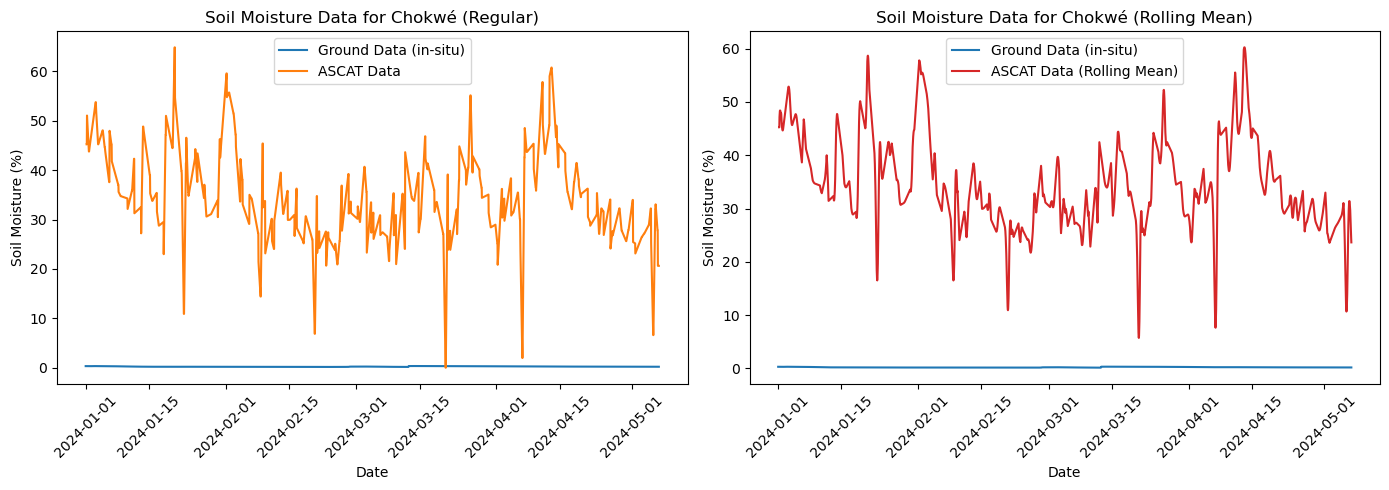

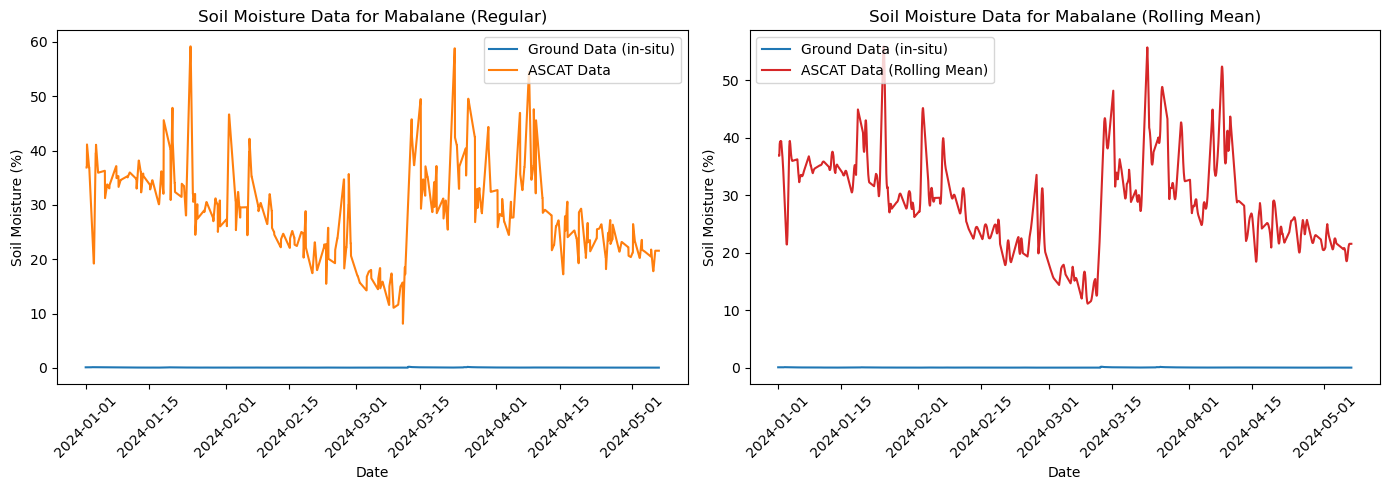

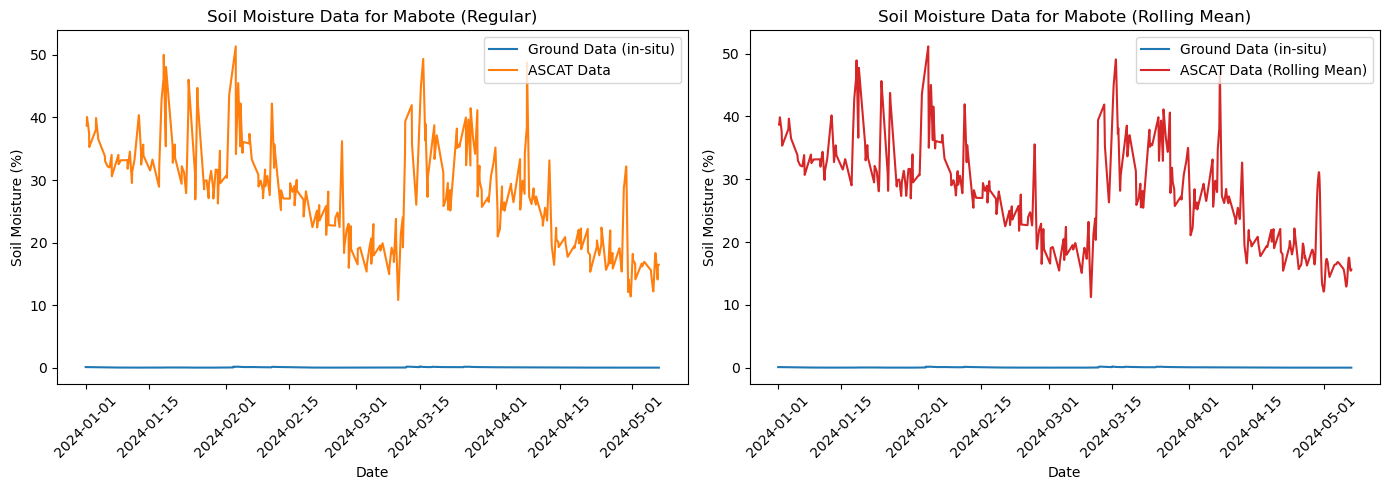

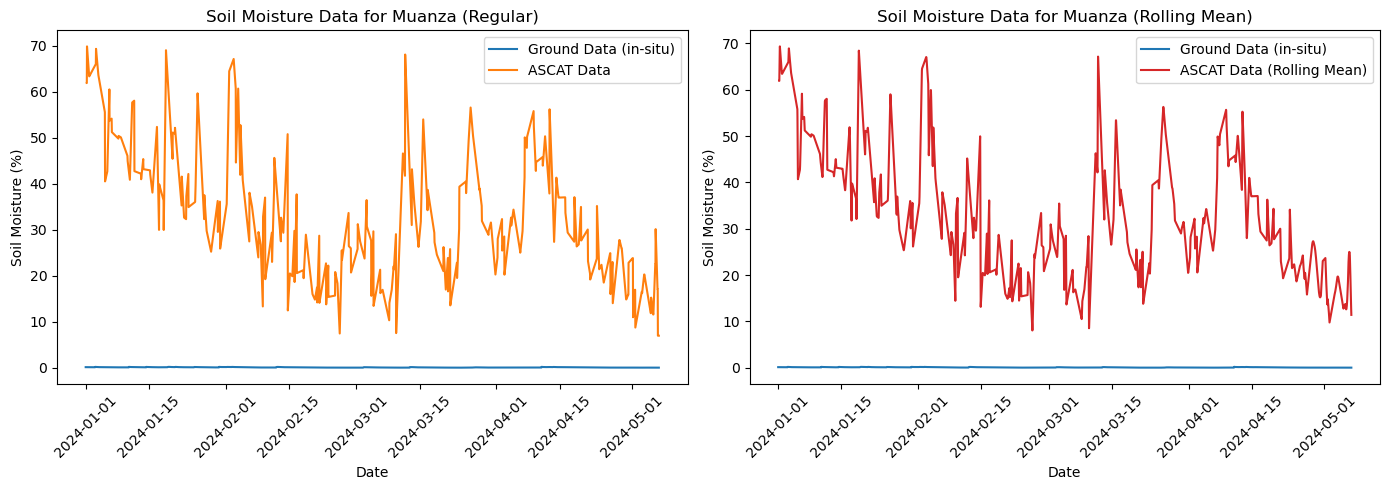

In [24]:
# Read the merged long CSV file
my_data = pd.read_csv('/home/jlinke/Documents/Geo/drysat/sync/test2/merge_wide/ALL_areas_merge_wide.csv')
area_names = ['Buzi','Chokwé','Mabalane','Mabote','Muanza']

# set parameters for the plot like area, timerange and amplifier 
start_date = '2024-01-01 00:00:00'  
end_date = '2024-05-07 00:00:00'  

for area_name in area_names:
    plot_location_data(my_data, area_name, start_date, end_date)
    

In [ ]:
# Calculating max. water content (g/cm^3) for normalization
# Average Particle density 2.65 g/cm^3
# Max. water content = 1 - (bulk density / particle density)
# To get the specific bulk density for one area values retrieved from https://soilgrids.org/


bulk_dens = [1.25, 1.4, 1.4, 1.35, 1.25] #"Buzi", "Chokwé", "Mabalane", "Mabote", "Muanza"
max_wat_list= []

for i in bulk_dens:

    wat = 1 -(i/2.65)
    max_wat_list.append(wat) 


mozam_areas = ["Buzi", "Chokwé", "Mabalane", "Mabote", "Muanza"]

max_wat = pd.DataFrame( data = list(zip(mozam_areas, max_wat_list)), columns = ["location", "maximum water content"] )

max_wat

,area,maximum water content
0,Buzi,0.528302
1,Chokwé,0.471698
2,Mabalane,0.471698
3,Mabote,0.490566
4,Muanza,0.528302
